<a href="https://colab.research.google.com/github/Andrian0s/ML4NLP1-2024-Tutorial-Notebooks/blob/main/tutorials_notebooks_in_class_2024/W12_Topic_Modeling_LDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this tutorial, we look into topic modeling using `Latent Dirichlet Allocation (LDA)`. In this tutorial we use [A Million News Headlines](https://www.kaggle.com/datasets/therohk/million-headlines/data) dataset, containing data of news headlines published over a period of nineteen years, sourced from Australian Broadcasting Corporation

  

### Import Necessary Libraries

In [1]:
import kagglehub
import pandas as pd
import os

### Download Dataset

In [2]:
# Download latest version
path = kagglehub.dataset_download("therohk/million-headlines")
df = pd.read_csv(os.path.join(path, 'abcnews-date-text.csv'))

100%|██████████| 21.4M/21.4M [00:02<00:00, 11.1MB/s]

Extracting files...


In [3]:
# Inspect Dataset
print(df['headline_text'].iloc[0])

# Select only 100000 samples
df = df.sample(n=100000, random_state=42)
df.head()

aba decides against community broadcasting licence


,publish_date,headline_text
1144371,20181017,virtual reality trial ahead of fire season in ...
282871,20070131,farmers prepare for ec funding
895099,20140810,the sunday inquisition august 10
764744,20130221,news csg reax
894276,20140806,rosetta spacecraft on final approach to comet ...


### Data Preprocessing

For preprocessing, we remove stopwords and lemmatize the words. Lemmatization reduces words to the base root - words such as "walking", "walks" and "walked" are reduced to their root word "walk".

In [4]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

In [5]:
# Downloading dependencies
nltk.download('punkt_tab')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))

# Function to lemmatize and remove stopwords from the text data
def preprocess(text):
    text = text.lower()
    words = word_tokenize(text)
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return " ".join(words)


# Applying the function to headlines
df['preprocessed_text'] = df['headline_text'].apply(lambda x: preprocess(x))

# Convert to list
text = df['preprocessed_text'].tolist()
print(text[:10])

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


['virtual reality trial ahead fire season south australia', 'farmer prepare ec funding', 'sunday inquisition august 10', 'news csg reax', 'rosetta spacecraft final approach comet landing', "milne 's lawyer want access police note", 'needle found mandarin amid sa fruit contamination incident', 'nrn prawn plan', 'tiger wood dominates president cup day three', 'long take lose fitness']


### LDA

LDA is a generative probabilistic model that assumes each topic is a mixture over an underlying set of words, and each document is a mixture of over a set of topic probabilities. [This](https://scikit-learn.org/1.5/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html) is the link for official LDA documentation from sklearn.

In [6]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer


NUM_LDA_TOPICS = 5 # Number of topics to use for LDA
NUM_FEATURES = 10000 # Number of words to keep in the vocabulary - used in CountVectorizer
MAX_DF = 0.95 # Remove words that appear too frequently. Used in CountVectorizer. In this case, words that appear in more than 95% documents are removed.
MIN_DF = 100 # Remove terms that appear too infrequently. Used in CountVectorizer. In this case, terms that appear in less than 100 documents are removed

In [7]:
# Use CountVectorizer to generate Bag of Words

tf_vectorizer = CountVectorizer(max_df=MAX_DF, min_df=MIN_DF, max_features=NUM_FEATURES)
tf = tf_vectorizer.fit_transform(text)
tf_feature_names = tf_vectorizer.get_feature_names_out()

In [8]:
# LDA

lda = LatentDirichletAllocation(n_components=NUM_LDA_TOPICS,
                                max_iter=5,
                                learning_method='online',
                                random_state=42).fit(tf)

In [9]:
for topic_idx, topic in enumerate(lda.components_):
    print(f'Topic {topic_idx}:', end=' ')
    print(' '.join([tf_feature_names[i] for i in topic.argsort()[:-12 - 1:-1]]))

Topic 0: police win crash wa day car man australia world two set mp
Topic 1: say nsw qld attack change hit death government market coast take farmer
Topic 2: new plan call council australian get home charged case drug killed open
Topic 3: man court govt year water face sa election murder charge sydney first
Topic 4: fire interview back report hospital health claim school south cut national minister


It could be difficult to identify the exact topics in this setting. However, the following could be some of the probable topic themes.  

Topic 0: Road Accidents  - Car, Crash, Police (maybe)

Topic 1: Places (NSW - New South Wales ; QLD - Queensland)

Topic 2: Criminal Cases (Drug, Killed, Case, Charged)

Topic 3: Judiciary (Court, Govt)

Topic 4: Emergencies (Fire, Hospital, Health)

### Visualization using WordCloud

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


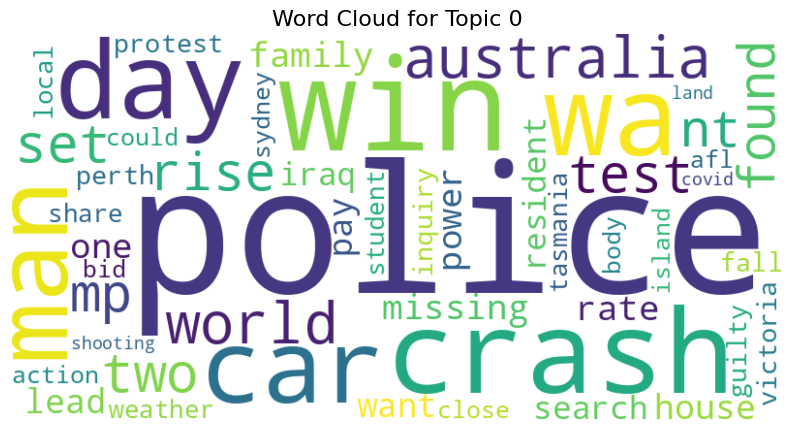

In [12]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Get the top 50 words for the first topic
TOP_N_WORDS = 50
topic_idx = 0  # First topic
topic = lda.components_[topic_idx]
top_words_indices = topic.argsort()[:-TOP_N_WORDS - 1:-1]
top_words = {tf_feature_names[i]: topic[i] for i in top_words_indices}

# Generate a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(top_words)

# Display the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title(f"Word Cloud for Topic {topic_idx}", fontsize=16)
plt.show()